In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder

In [2]:
gc.enable()

In [3]:
news = pd.read_csv("./datasets/news_sample.csv")
market = pd.read_csv("./datasets/marketdata_sample.csv")

In [6]:
news['time'] =pd.to_datetime(news.time)
news['time'] = news['time'].dt.strftime('%Y-%m-%d')

market['time'] =pd.to_datetime(market.time)
market['time'] = market['time'].dt.strftime('%Y-%m-%d')

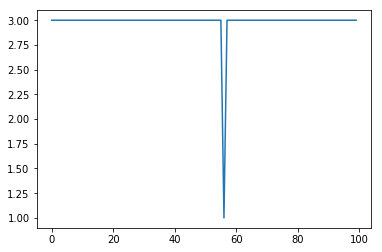

In [28]:
plt.plot(news[[5]])

In [8]:
market

,time,assetCode,assetName,universe,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10
0,2007-02-01,A.N,Agilent Technologies Inc,1.0,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672
1,2007-02-01,AAI.N,AirTran Holdings Inc,0.0,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803
2,2007-02-01,AAP.N,Advance Auto Parts Inc,1.0,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433
3,2007-02-01,AAPL.O,Apple Inc,1.0,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425
4,2007-02-01,ABB.N,ABB Ltd,1.0,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994
5,2007-02-01,ABC.N,AmerisourceBergen Corp,1.0,1657300.0,52.37,52.40,-0.000191,0.008468,NaN,NaN,0.089000,0.077746,NaN,NaN,0.058680
6,2007-02-01,ABD.N,ACCO Brands Corp,0.0,1186200.0,23.63,24.13,-0.020721,-0.007404,NaN,NaN,0.005104,0.026809,NaN,NaN,-0.044285
7,2007-02-01,ABM.N,ABM Industries Inc,0.0,301200.0,26.19,25.90,0.013545,0.014890,NaN,NaN,0.068980,0.047311,NaN,NaN,0.016578
8,2007-02-01,ABT.N,Abbott Laboratories,1.0,5692300.0,52.87,52.50,-0.002453,-0.004739,NaN,NaN,0.001515,-0.004928,NaN,NaN,0.009861
9,2007-02-01,ABV.N,Companhia de Bebidas das Americas Ambev,1.0,401800.0,52.46,52.10,0.014112,0.024784,NaN,NaN,0.042321,0.027411,NaN,NaN,0.012917
